# FS3 - MP analysis of all normally induced fates

In [1]:
import os

dir = r"D:\OneDrive - Universität Wien\Adameyko Lab\FS3_MP\fluorescence_images"
os.chdir(dir)
dirs = os.listdir(".")
print(dirs)

['ab testing', 'all_fates_neg_ctr', 'all_fates_pax6_isi12_sox10', 'all_fates_six1_isi12_sox10', 'Lost and Found Florian']


In [2]:
dirs = dirs[2:4]
print(dirs)

['all_fates_pax6_isi12_sox10', 'all_fates_six1_isi12_sox10']


In [3]:
from micropattern_analysis import *
from skimage.filters import threshold_triangle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
images = {}
dapi_channel_number = 3
frames = []

In [5]:
for file in gather_files(dirs):
    img = iio.imread(file)
    img = maximise_img_channels(img)

    images.update({file: img})

    dapi_img = img[dapi_channel_number]
    img_mask = create_img_mask(img, dapi_img, threshold_triangle)
    applied_img_mask = apply_img_mask(img, img_mask)
    center_of_mass = get_center_of_mass(img_mask, dapi_img)
    cords = expand_coordinate_matrix(dapi_img)

    dist = calculate_distances(cords, center_of_mass)

    file_params = os.path.basename(file).split("_")
    channel_names = file_params[6:12][::2]
    channel_names = list(map(lambda x: x.upper(), channel_names))
    channel_names.append("DAPI")
    mp_type = file_params[4:5]

    df_mini = generate_data_frame(cords, applied_img_mask, channel_names, Distances=dist)

    img_props = iio.improps(file)
    img_meta = iio.immeta(file)
    if img_props.spacing:
        mean_res = np.mean(1 / np.array(img_props.spacing))
    elif img_meta["ScanInformation"]["SampleSpacing"]:
        mean_res = img_meta["ScanInformation"]["SampleSpacing"]
    else:
        mean_res = 1

    df_mini = group_distances(df_mini, channel_names)
    df_mini = scale_distances(df_mini, mean_res)
    df_mini = normalize_distances(df_mini, channel_names)
    df_mini = smooth_distances(df_mini, channel_names, sigma=5)
    df_mini["MP Type"] = np.repeat(mp_type, df_mini.shape[0])

    frames.append(df_mini)

In [6]:
df = pd.concat(frames)

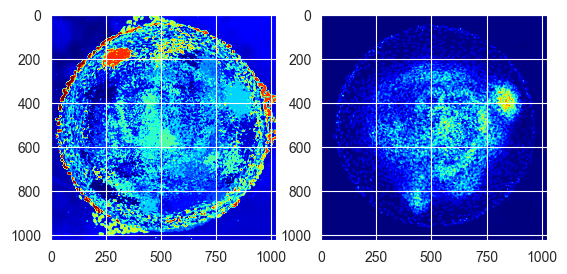

In [24]:
img_keys = [f for f in images.keys() if "800um" in f]

imgs = np.array(list(map(lambda x: images.get(x), img_keys)))

ind = imgs.argmax(axis=0)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(ind[3], cmap="jet")
ax[1].imshow(imgs[5][3], cmap="jet")
plt.show()

In [43]:
d = ["800um", "900um", "stencil"]
s = map(str.lower, ("PAX6", "SIX1", "SOX10", "ISI12"))
key_func = lambda x: [f for f in images.keys() if x in f]
[f for f in key_func("")]

TypeError: 'in <string>' requires string as left operand, not list

In [101]:
import matplotlib.ticker as ticker


def plot_mp_types(pattern_size_order=("800um", "900um", "stencil"),
                  staining_order=("PAX6", "SIX1", "SOX10", "ISI12")):
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(round(x * mean_res)))
    staining_order = list(map(str.lower, staining_order))
    img_map = {
        "pax6": 0,
        "six1": 0,
        "sox10": 1,
        "isi12": 2
    }
    pos_map = {
        "800um": 800,
        "900um": 900,
        "stencil": 900
    }

    (fig, axes) = plt.subplots(len(channel_names) * 2, 3, figsize=(35, 20))
    for i, so in zip(range(len(axes)), list(np.repeat(staining_order, 2))):
        if i % 2 == 0:
            cur_so = [f for f in images.keys() if so in f]
            for axi, pos in zip(axes[i], pattern_size_order):
                cur_pos = [f for f in cur_so if pos in f]
                key = np.random.choice(cur_pos)
                img = images.get(key)[img_map.get(so)]
                im = axi.imshow(img, cmap="jet")
                #axi.set_ylabel(channel_names[i])
                #ax.xaxis.set_major_formatter(ticks)
                #ax.yaxis.set_major_formatter(ticks)
                #pos = fig.add_axes([0.93, 0.1, 0.02, 0.35])
                #fig.colorbar(im, cax=pos)
                axi.set_title(pos) if i == 0 else None
        else:
            for axi, pos in zip(axes[i], pattern_size_order):
                df_sub = df[df["MP Type"] == pos]
                df_sub.reset_index(inplace=True)
                g = sns.lineplot(df_sub, x="Distances", y=so.upper(), ax=axi)
                axi.set_xlim(0, pos_map.get(pos)/2)
                #axi.set_ylim(0, 1)
                axi.set_ylabel("Average Intensity [au]") if pos == pattern_size_order[0] else None
                axi.set_xlabel("")
                pos = axi.get_position()
                axi.text(pos.x0-0.25, pos.y0+0.25, so.upper()) if pos == pattern_size_order[0] else None
                print(pos.x0, pos.y0)
    fig.supxlabel("Distance [µm]")
    plt.grid(False)
    plt.subplots_adjust(left=0.25)
    plt.show()

0.125 0.6997872340425533
0.3985294117647059 0.6997872340425533
0.6720588235294118 0.6997872340425533
0.125 0.5031914893617022
0.3985294117647059 0.5031914893617022
0.6720588235294118 0.5031914893617022
0.125 0.30659574468085105
0.3985294117647059 0.30659574468085105
0.6720588235294118 0.30659574468085105
0.125 0.10999999999999999
0.3985294117647059 0.10999999999999999
0.6720588235294118 0.10999999999999999


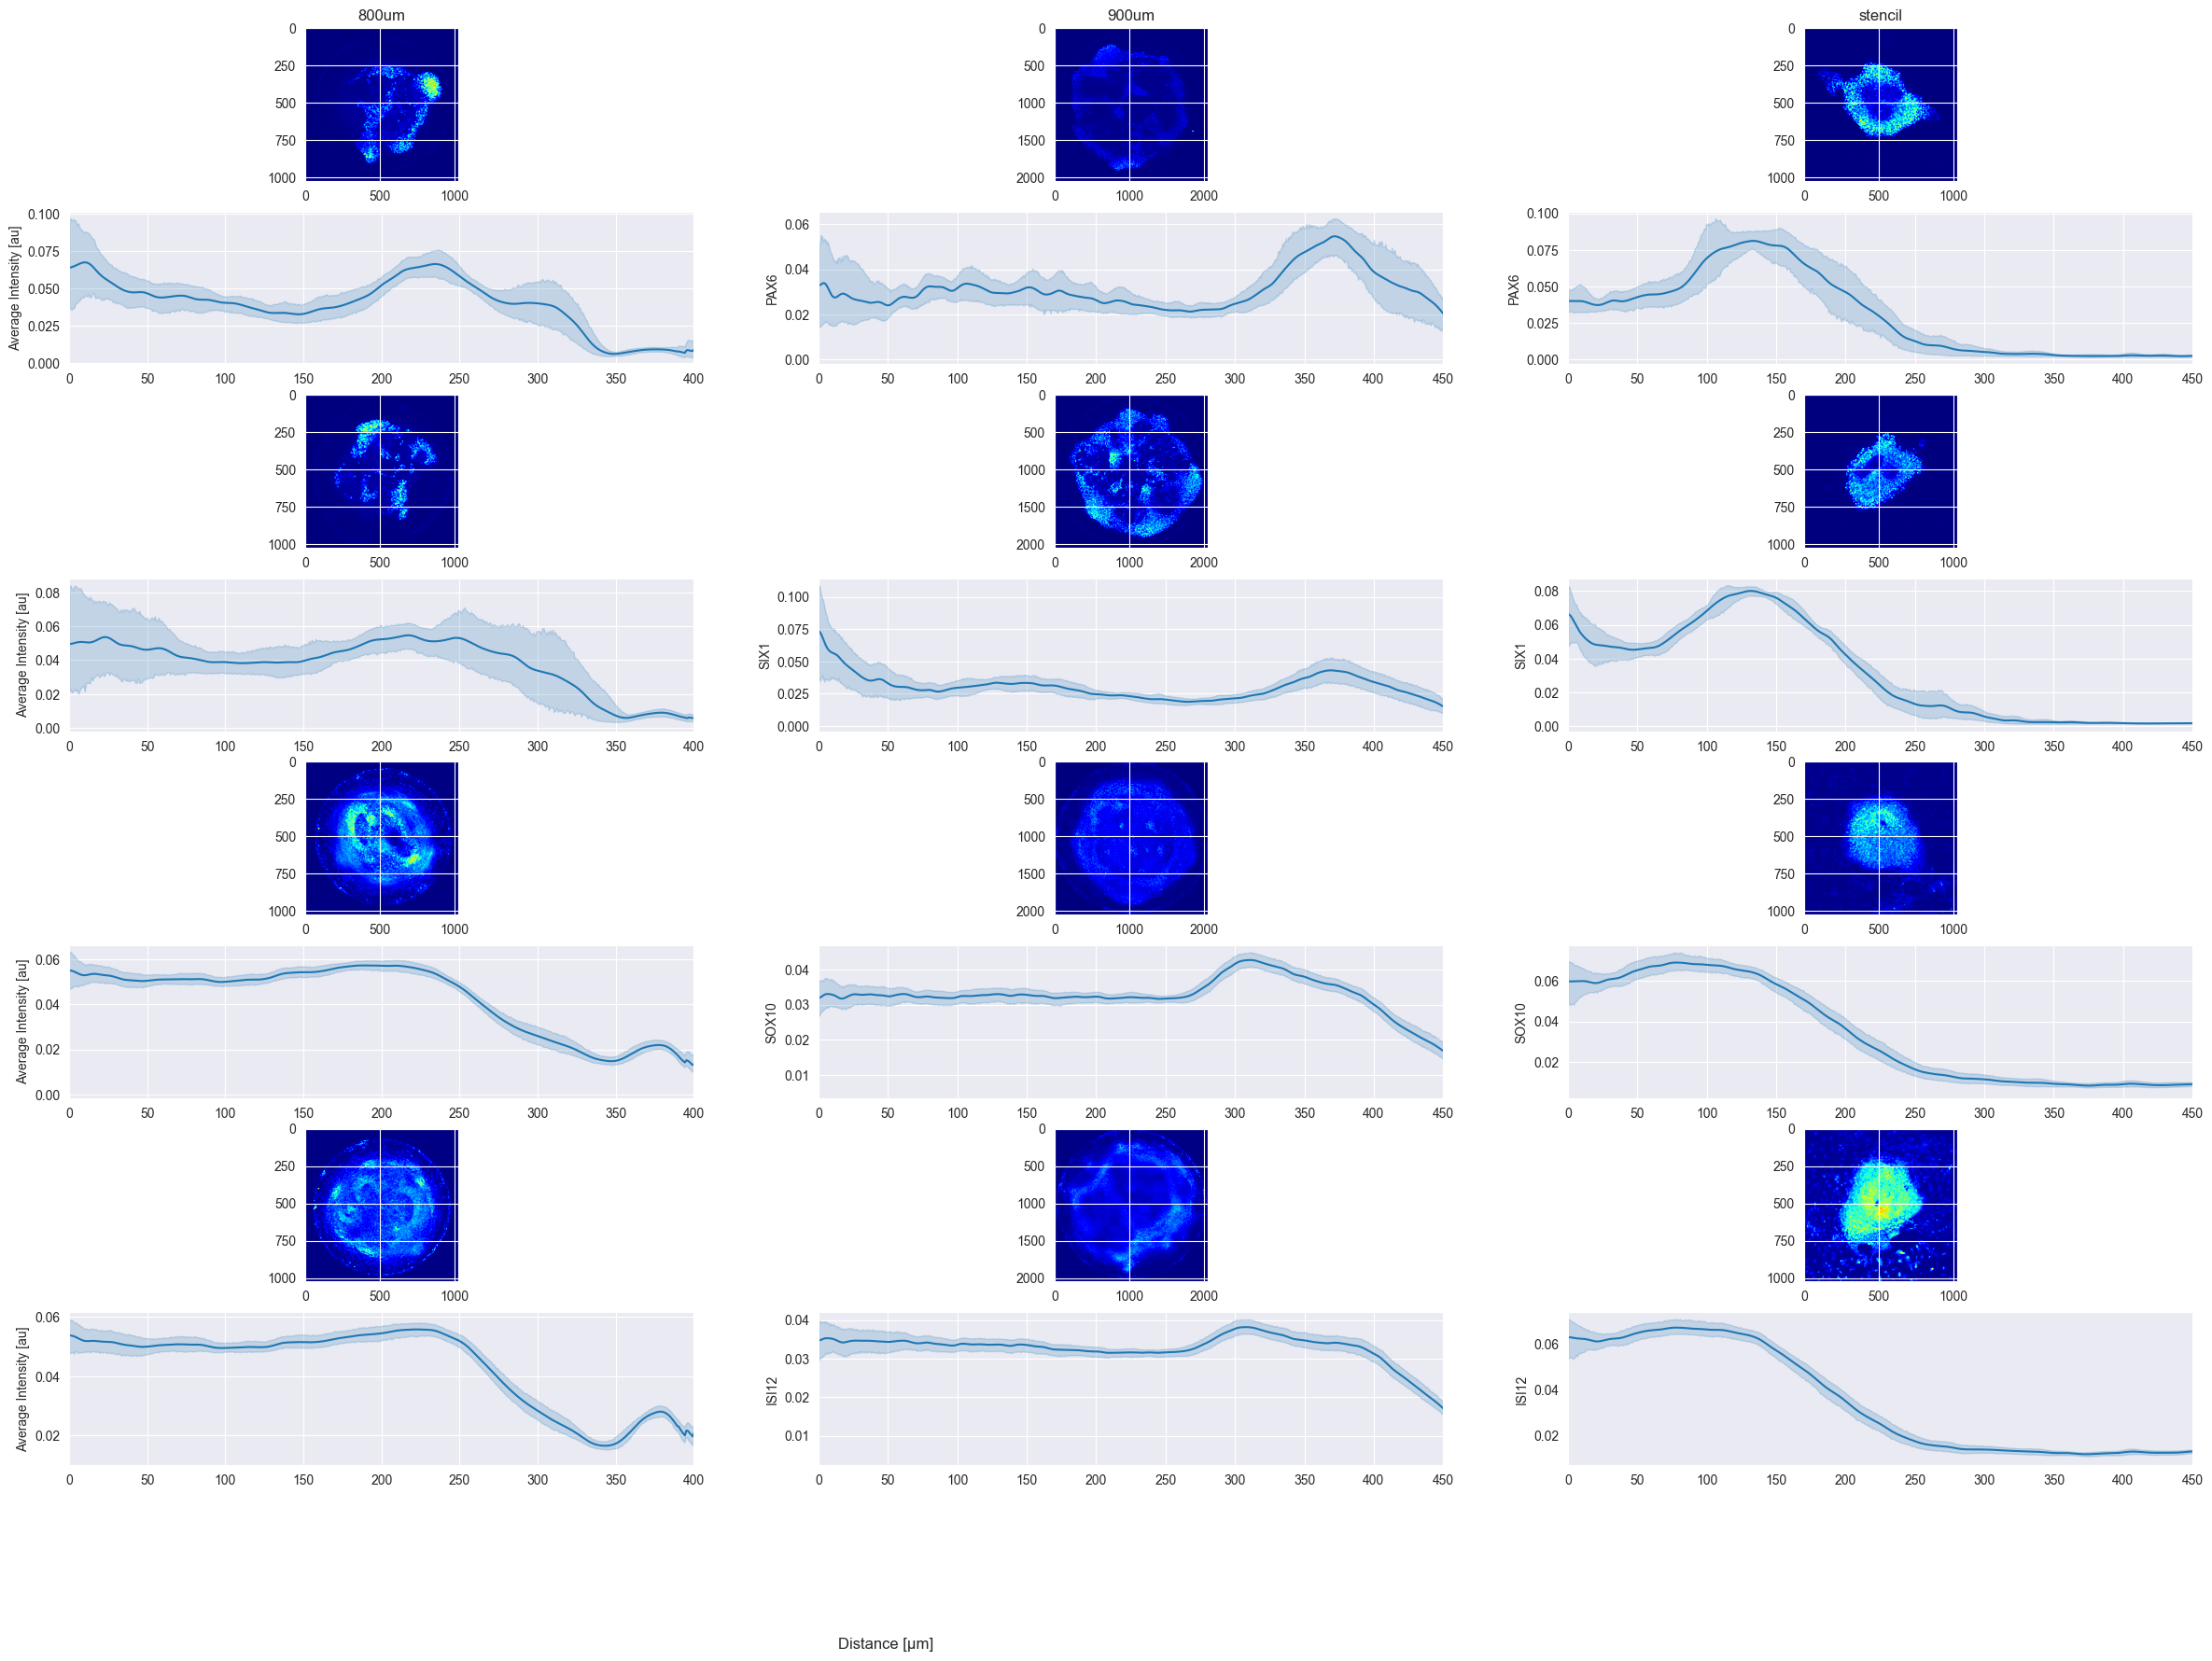

In [102]:
plot_mp_types()

In [90]:
df[df["MP Type"] == "800um"].groupby("Distances").max()

,x,y,PAX6,SOX10,ISI12,DAPI,MP Type,SIX1
Distances,,,,,,,,
0.000000,534.000000,528.000000,0.146315,0.088481,0.071729,0.087791,800um,0.133434
0.830266,534.000000,528.000000,0.145415,0.087827,0.071324,0.087743,800um,0.133344
1.660532,534.000000,528.000000,0.143685,0.086560,0.070539,0.087664,800um,0.133166
2.490797,534.000000,528.000000,0.141254,0.084761,0.069420,0.087580,800um,0.132895
3.321063,534.000000,528.000000,0.138289,0.082535,0.069583,0.087526,800um,0.132519
...,...,...,...,...,...,...,...,...
494.838429,839.769231,29.076923,0.006778,0.017722,0.030862,0.014958,800um,NaN
495.668695,842.111111,29.222222,0.006650,0.017061,0.029326,0.014273,800um,NaN
496.498961,842.500000,28.333333,0.006554,0.016524,0.028085,0.013721,800um,NaN
